## Place Cell

In [1]:
%config Completer.use_jedi = False

In [2]:
# Temp / hack - turn off warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from convnwb.io import load_nwbfile

from spiketools.measures.collections import detect_empty_time_ranges
from spiketools.spatial.occupancy import (compute_occupancy, compute_trial_occupancy, compute_bin_edges, 
                                          compute_bin_assignment, compute_bin_counts_pos, normalize_bin_counts)
from spiketools.spatial.utils import compute_pos_ranges, compute_bin_width
from spiketools.spatial.information import compute_spatial_information
from spiketools.spatial.place import compute_place_bins, compute_trial_place_bins
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.plts.spatial import plot_positions, plot_heatmap, create_heat_title, plot_position_by_time
from spiketools.plts.utils import make_axes
from spiketools.plts.annotate import color_pvalue
from spiketools.utils import set_random_seed
from spiketools.utils.trials import recombine_trial_data
from spiketools.utils.extract import get_range, get_values_by_time_range, get_values_by_times,get_inds_by_times
from spiketools.utils.epoch import epoch_data_by_range, epoch_spikes_by_event,epoch_spikes_by_range

from spiketools.stats.anova import fit_anova

from spiketools.stats.anova import create_dataframe_bins

In [4]:
import seaborn as sns
sns.set_context('talk')

In [5]:
import sys
sys.path.append('../code')
from utils import select_movement
from models import create_df_place, fit_anova_place

## Set Up

In [6]:
# Set random seed, for consistency shuffling
set_random_seed(101)

# Define the base data folder
data_folder = '/Users/weijiazhang/Data/Train_NWB'
# Define subject information
session = {
    'experiment' : 'TRAIN',
    'subject' : 'R1219C',
    'session' : 0    
}

In [7]:
# Define occupancy settings: minimum required occupancy (in seconds) & speed threshold
min_occ = 1.0
occ_setnan = True
speed_thresh = 5e-6
time_thresh = 0.2

# Collect settings for occupancy
occ_kwargs = {'minimum' : min_occ,
              'set_nan' : occ_setnan,'normalize': False}


# Define any quality measures
empty_time_bin = 0.25

# Define bins to use 
bins =  40

# Shuffle Settings
shuffle_approach = 'CIRCULAR'
# shuffle_approach = 'BINCIRC'
n_surrogates = 25

if shuffle_approach == 'CIRCULAR':
    shuffle_kwargs = {}
if shuffle_approach == 'BINCIRC':
    shuffle_kwargs = {'shuffle_min' : 20000}
    
uind = 0

# Set which analysis method to run
METHOD = 'ANOVA'

## Load Data

In [8]:
# Load NWB file
nwbfile = load_nwbfile(session, data_folder)

In [9]:
# Get task time range
task_range = [0, nwbfile.trials.stop_time[-1]]

In [10]:
#track_range = [nwbfile.acquisition['boundaries']['track_range'].data[:]]
track_range = [-34, 34]
print('Track Range: ', track_range)

Track Range:  [-34, 34]


In [11]:
# Get the navigation time ranges
move_starts = nwbfile.trials.movement_start_time[:]
move_stops = nwbfile.trials.movement_stop_time[:]

In [12]:
# Get position data, selecting from movement periods, and recombine across trials
ptimes_trials, positions_trials = select_movement(\
    nwbfile.acquisition['position']['player_position'], move_starts, move_stops, False)
ptimes, positions = recombine_trial_data(ptimes_trials, positions_trials)

In [13]:
# Get speed data, selecting from movement periods
stimes, speed = select_movement(nwbfile.processing['position_measures']['speed'], move_starts, move_stops)

### Extract Spike Data

In [14]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
print('Number of units: {}'.format(n_units))

Number of units: 23


In [15]:
# Detect any empty ranges in the recording, and add them to shuffle arguments
empty_ranges = detect_empty_time_ranges(\
    [nwbfile.units.get_unit_spike_times(ii) for ii in range(n_units)], empty_time_bin, task_range)
shuffle_kwargs['drop_time_range'] = empty_ranges

In [16]:
# Extract spikes for a unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)
spikes.shape

(27929,)

### Position Data

In [17]:
# Compute position ranges
x_min_track, x_max_track = compute_pos_ranges(positions)

print('Min Track Position: ', x_min_track)
print('Max Track Position: ', x_max_track)

Min Track Position:  -33.9997
Max Track Position:  34.851


In [18]:
# Compute position ranges
res_pos = nwbfile.trials.response_position[:]
x_min_res, x_max_res = compute_pos_ranges(res_pos)

print('Min Track Position: ', x_min_res)
print('Max Track Position: ', x_max_res)

Min Track Position:  -34.0
Max Track Position:  25.5868


In [19]:
spike_positions = get_values_by_times(ptimes, positions, spikes, threshold=time_thresh)

In [20]:
# Check binning
bin_edges = compute_bin_edges(positions, bins)
bin_edges.shape

(41,)

In [21]:
bin_width = compute_bin_width(bin_edges)
print('Bin widths: {:1.2f}'.format(bin_width))

Bin widths: 1.72


#### Check Spike Positions

In [22]:
## spike times that close to specific positions with time threshold 0.2
spike_times = get_values_by_times(ptimes, ptimes, spikes, threshold=time_thresh)

## spike positions that close to specific positions with time threshold 0.2
spike_positions = get_values_by_times(ptimes, positions, spikes, threshold=time_thresh)
stime_trials, spike_trials = epoch_data_by_range(spike_times, spike_positions, move_starts, move_stops, reset=False)
reset_stime_trials = stime_trials - stime_trials[0][0]



#### Plot position by time
- 'o': marked object position, appear time
- 'x': marked reponse position, response time

In [23]:
start_time = nwbfile.trials['start_time']
stop_time = nwbfile.trials['stop_time']
pos = nwbfile.acquisition['position']['player_position'].data[:]
time_stamps = nwbfile.acquisition['position']['player_position'].timestamps[:]
epoch_pos = epoch_data_by_range(time_stamps,pos,start_time,stop_time)
obj_pos = nwbfile.trials['object_position'].data[:]
res_pos= nwbfile.trials.response_position[:]
res_time = nwbfile.trials.response_time[:]

In [24]:
ind_obj = np.zeros(len(epoch_pos[0]))
for i in range(len(epoch_pos[0])):
    ind_obj[i] = get_inds_by_times(np.array(epoch_pos[1][i]),np.array([obj_pos[i]]))
    
obj_time = np.zeros(len(epoch_pos[0]))
for i in range(len(ind_obj)):
    ind = int(ind_obj[i])
    obj_time[i] = epoch_pos[0][i][ind]

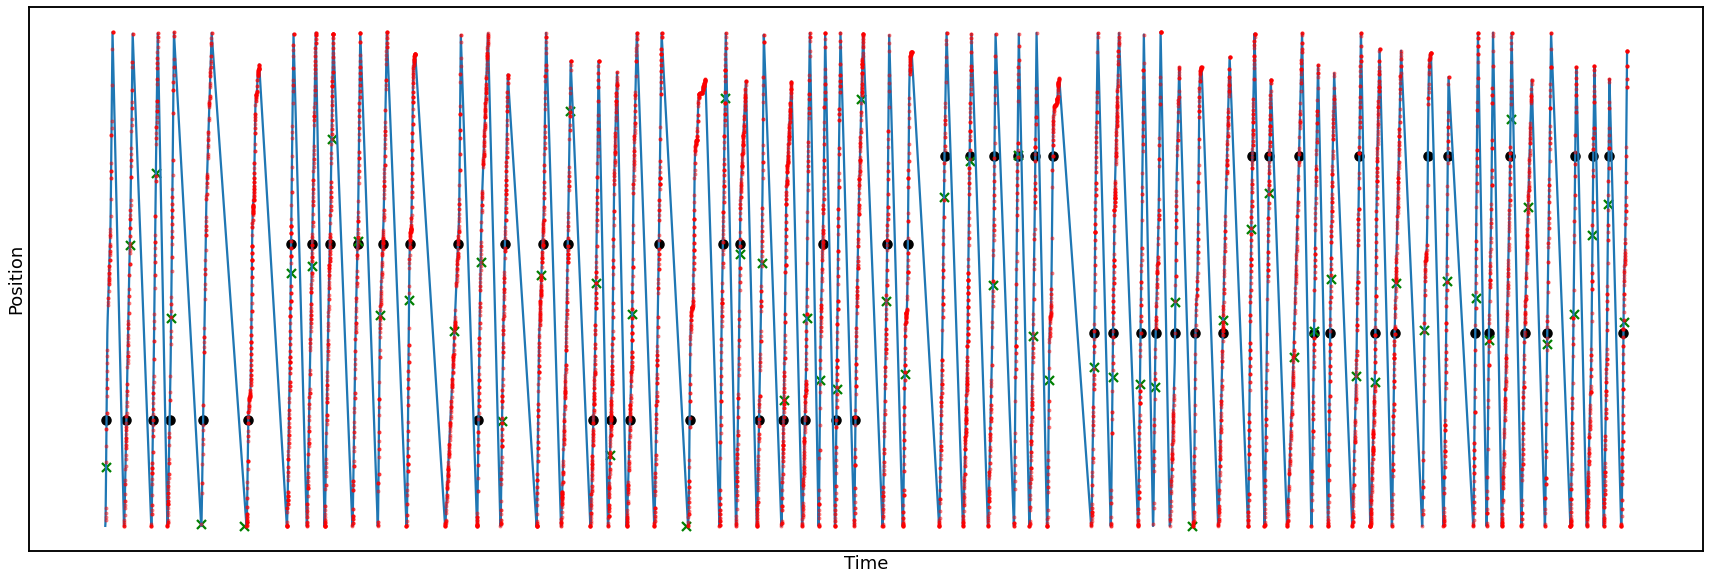

In [25]:
plot_position_by_time(ptimes,positions,spike_times,spike_positions,alpha=1, figsize=(30, 10))
plt.scatter(obj_time, obj_pos, marker='o',  color='black')
plt.scatter(res_time,res_pos,marker = 'x', color = 'green')

#### Example Trials

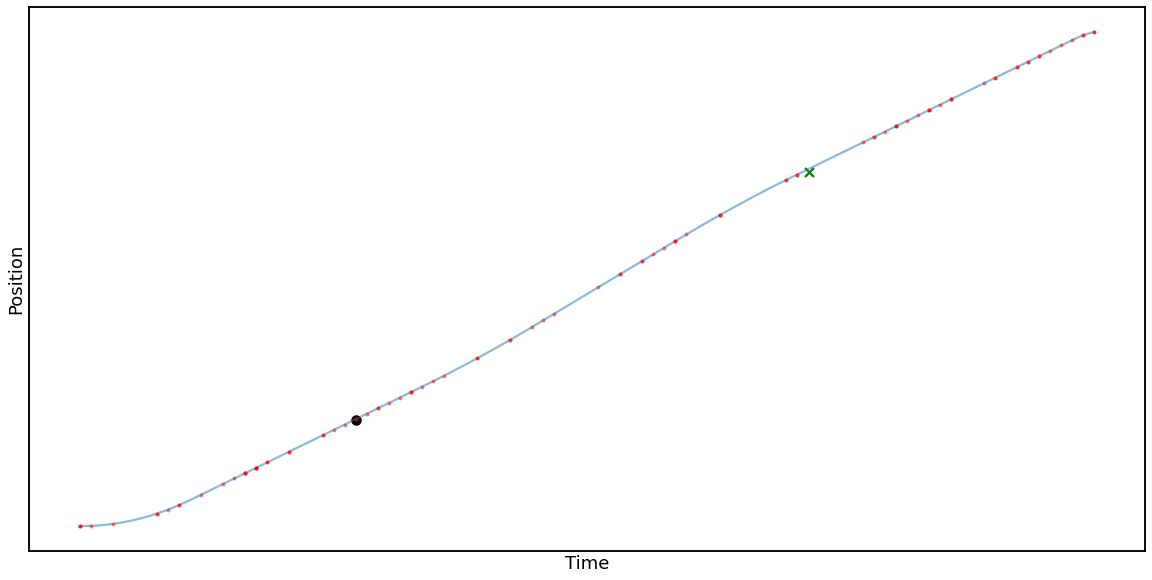

In [26]:
n_trial = 2
plot_position_by_time(ptimes_trials[n_trial],positions_trials[n_trial],stime_trials[n_trial], spike_trials[n_trial],alpha=0.5, figsize=(20, 10))
plt.scatter(obj_time[n_trial], obj_pos[n_trial], marker='o',  color='black')
plt.scatter(res_time[n_trial],res_pos[n_trial],marker = 'x', color = 'green')

## Occupancy: 
- Total amount of time spent in each bin 
- Account for speed and positions
- Across all trials
- track ramge set to [-32 32]

### Spatially Binned Time Occupancy

In [27]:
## Amount of time subject spent in each VR bins 
occ = compute_occupancy(positions, ptimes, bins, track_range,
                        speed, speed_thresh, time_thresh, **occ_kwargs)

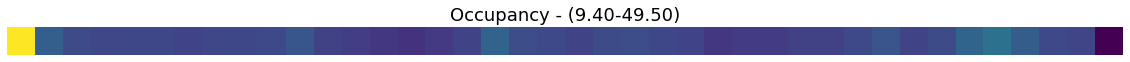

In [28]:
# Plot occupancy
plot_heatmap(occ, figsize=(20, 20), title=create_heat_title('Occupancy', occ))

### Spatially Binned  Firing 

#### session level

In [29]:
# Compute summary map of bin firing
bin_firing = compute_bin_counts_pos(spike_positions, bins, track_range)

In [30]:
# Normalize bin firing by occupancy
normed_bin_firing = normalize_bin_counts(bin_firing, occ)

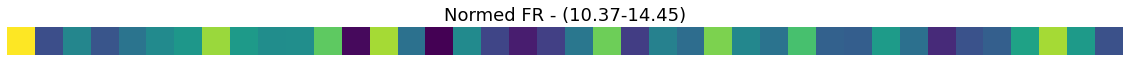

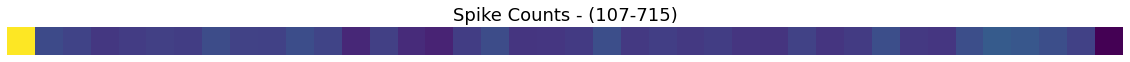

In [31]:
# Plot occupancy-normalized spatial firing
plot_heatmap(normed_bin_firing,figsize=(20, 7), title=create_heat_title('Normed FR', normed_bin_firing))

# Check the firing map
plot_heatmap(bin_firing,figsize=(20, 7), title=create_heat_title('Spike Counts', bin_firing))

#### trial level

In [32]:
# Check the number of trials
print('Number of trials: {}'.format(len(nwbfile.trials)))

Number of trials: 64


In [33]:
# Compute trial level occupancy: amount of time spend in each spatial bin
trial_occupancy = compute_trial_occupancy(positions, ptimes, bins, move_starts, move_stops)
trial_occupancy

array([[0.49996484, 0.29997876, 0.09999292, ..., 0.09999316, 0.1999856 ,
        0.19998608],
       [0.89993677, 0.29997876, 0.39997192, ..., 0.1999856 , 0.19998608,
        0.19998608],
       [0.69995044, 0.299979  , 0.29997876, ..., 0.19998608, 0.29997876,
        0.19998584],
       ...,
       [0.89993677, 0.49996484, 0.39997144, ..., 0.19998608, 0.19998584,
        0.19998584],
       [0.69995044, 0.299979  , 0.29997852, ..., 0.19998608, 0.09999268,
        0.19998584],
       [0.7999436 , 0.29997876, 0.19998584, ..., 0.09999292, 0.19998584,
        0.19998608]])

In [34]:
# Compute trial level occupancy: amount of spikes per trial per spatial bin 
trial_place_bins_3d = compute_trial_place_bins(spikes,positions,ptimes,bins, move_starts,move_stops,track_range, trial_occupancy =trial_occupancy,time_threshold = time_thresh )
trial_place_bins_3d

array([[ 4.00028127,  6.66713871,  0.        , ...,  0.        ,
         0.        ,  5.00034792],
       [ 7.77832427,  6.66713871,  7.50052647, ...,  5.00036013,
        10.00069585,  0.        ],
       [ 7.1433629 , 16.6678332 ,  3.33356935, ..., 20.0013917 ,
        10.00070806, 10.00070806],
       ...,
       [15.55664854, 16.00112508, 22.50160687, ..., 35.00243547,
         0.        ,  0.        ],
       [18.57274354, 20.00139984, 26.66857653, ...,  0.        ,
         0.        ,  0.        ],
       [12.50088126,  6.66713871, 10.00070806, ..., 40.00283223,
        35.0024782 ,  0.        ]])

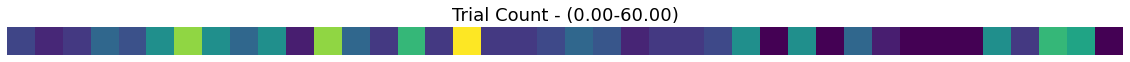

In [35]:
# Check an example trials' spatial firing
t_ind = 63
plot_heatmap(trial_place_bins_3d[t_ind, :],figsize=(20, 7),
             title=create_heat_title('Trial Count', trial_place_bins_3d[t_ind, :]))

## Statistical Analysis 

### Spatial Information

In [36]:
# Create shuffled time series for comparison
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates)

In [37]:
spike_info = compute_spatial_information(bin_firing, occ)
print('Spike Information: ', spike_info)

Spike Information:  0.12444344913601087


#### Shuffle Comparisons

In [38]:
# Compute spatial information measures on surrogates
surrs = np.zeros(n_surrogates)
for ind, stimes in enumerate(times_shuffle):
    bin_firing = compute_place_bins(stimes, positions, ptimes, bins, 
                                    track_range, speed, speed_thresh, time_thresh)
    surrs[ind] = compute_spatial_information(bin_firing, occ, normalize=True)

In [39]:
# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(spike_info, surrs, verbose=True)

p-value: 0.00
z-score: 100.05


### ANOVA

In [40]:
trial_place_bins = compute_trial_place_bins(spikes, positions, ptimes, bins, move_starts, move_stops,
                                         track_range, speed, speed_thresh, time_thresh,
                                            trial_occupancy=trial_occupancy, flatten=True)

In [41]:
# Create the dataframe
df = create_df_place(trial_place_bins_3d)

In [42]:
f_val = fit_anova_place(df)
print('F value: ', round(f_val,3))

F value:  1.012


#### Shuffle Comparison

In [43]:
# Create shuffles
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)


In [44]:
# Compute measures on surrogates
surrogates = np.zeros(n_surrogates)
for ind, shuffle in enumerate(times_shuffle):
    place_trial_shuffle = compute_trial_place_bins(\
        shuffle, positions, ptimes, bins, move_starts, move_stops,trial_occupancy =trial_occupancy,time_threshold = 0.2 )
    
    surrogates[ind] = fit_anova_place(create_df_place(place_trial_shuffle))


p-value: 1.00
z-score: -4.95


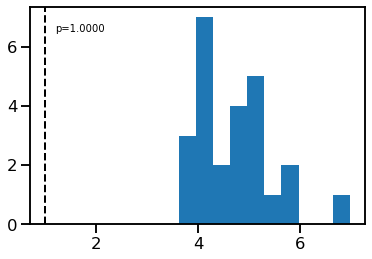

In [45]:
# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(f_val, surrogates, verbose=True,plot = True)

## All Cells Analysis

### Spike Information

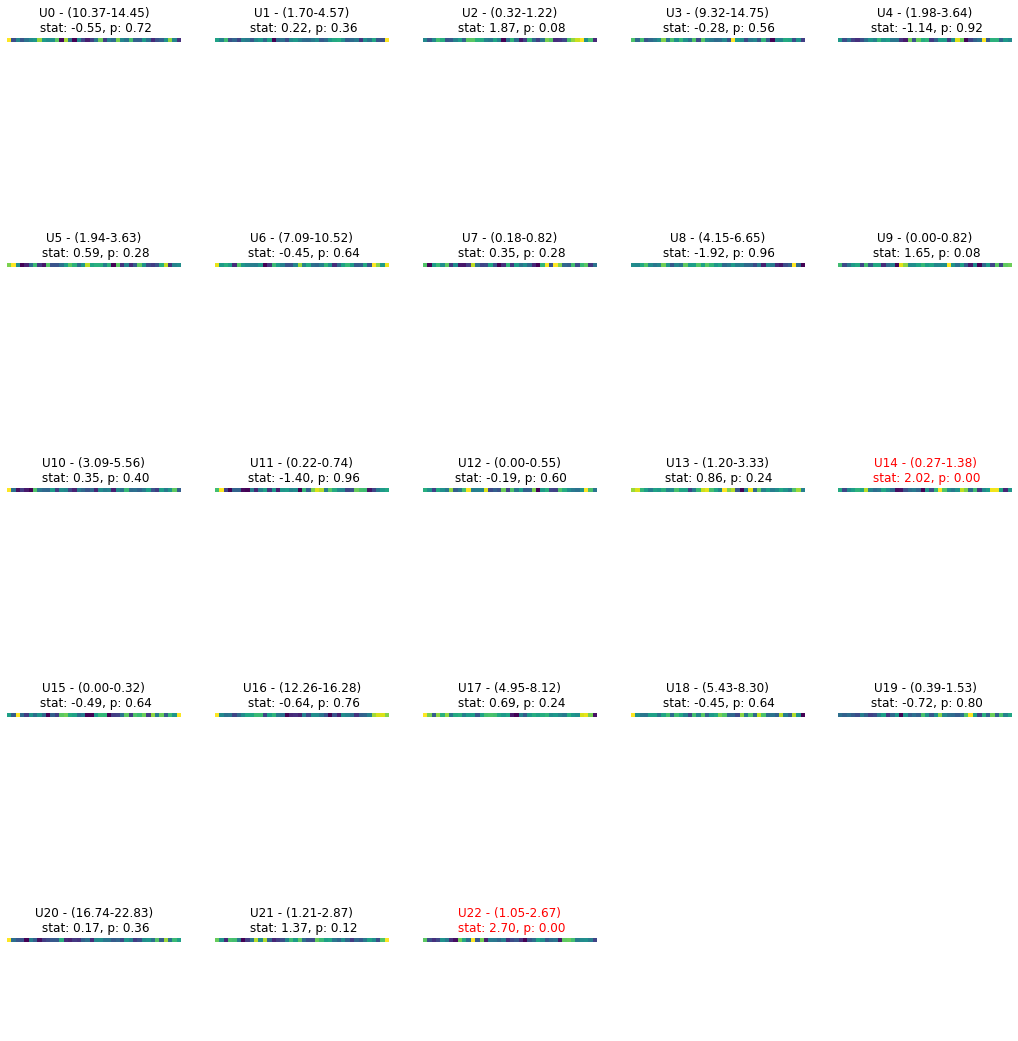

In [46]:
# Examine spatial firing across all cells
for ii,ax in zip(range(n_units),make_axes(n_units)):

    uspikes = nwbfile.units.get_unit_spike_times(ii)

    # Compute spatially binned firing map
    bin_firing = compute_place_bins(uspikes, positions, ptimes, bins, track_range,
                                    speed, speed_thresh, time_thresh, occ)
    

    data_value = compute_spatial_information(bin_firing, occ, normalize=False)
        
    surrogates = np.zeros(n_surrogates)
    times_shuffle = shuffle_spikes(uspikes, shuffle_approach, n_surrogates, **shuffle_kwargs)
    for ind, shuffle in enumerate(times_shuffle):
            
        bf_shuffle = compute_place_bins(shuffle, positions, ptimes, bins, track_range,
                                             speed, speed_thresh, time_thresh, occ)
        surrogates[ind] = compute_spatial_information(bf_shuffle, occ, normalize=False)

        
    p_val, z_score = compute_surrogate_stats(data_value, surrogates, plot=False, ax=ax)    

    
    # Plot occupancy-normalized spatial firing
    plot_heatmap(bin_firing, title=create_heat_title('U{}'.format(ii), bin_firing, z_score, p_val),
                 title_color=color_pvalue(p_val), title_fontsize=12, ax=ax)

### ANOVA

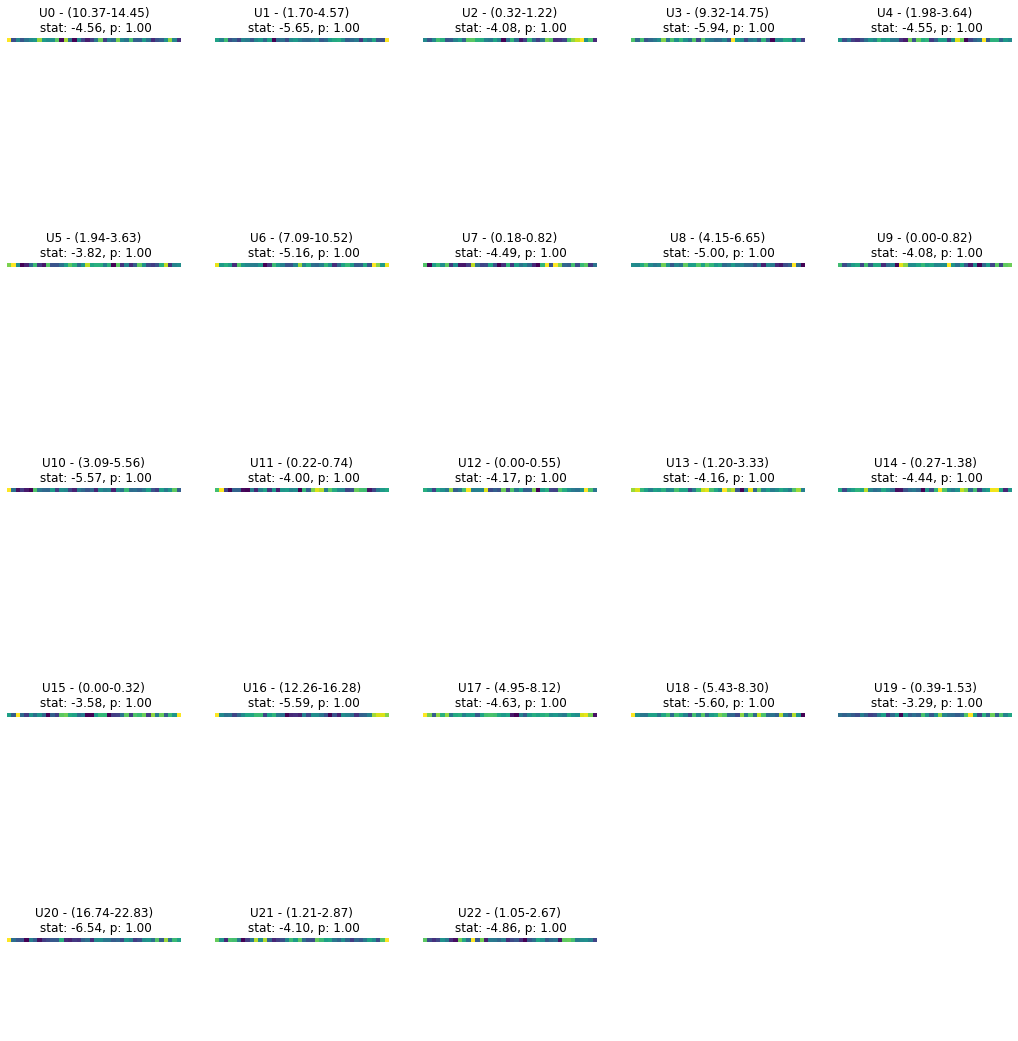

In [47]:
# Examine spatial firing across all cells
for ii,ax in zip(range(n_units),make_axes(n_units)):

    uspikes = nwbfile.units.get_unit_spike_times(ii)

    # Compute spatially binned firing map
    bin_firing = compute_place_bins(uspikes, positions, ptimes, bins, track_range,
                                    speed, speed_thresh, time_thresh, occ)
    
    utrial_place_bins = compute_trial_place_bins(spikes, positions, ptimes, bins, move_starts, move_stops,
                                         track_range, speed, speed_thresh, time_thresh,
                                            trial_occupancy=trial_occupancy)
    
    
    surrogates = np.zeros(n_surrogates)
    times_shuffle = shuffle_spikes(uspikes, shuffle_approach, n_surrogates, **shuffle_kwargs)
    for ind, shuffle in enumerate(times_shuffle):
            
        uplace_trial_shuffle = compute_trial_place_bins(\
                shuffle, positions, ptimes, bins, move_starts, move_stops,
                                         track_range, speed, speed_thresh, time_thresh,
                                            trial_occupancy=trial_occupancy)
        surrogates[ind] = fit_anova_place(create_df_place(uplace_trial_shuffle))
        
    p_val, z_score = compute_surrogate_stats(data_value, surrogates, plot=False, ax=ax)    

    
    # Plot occupancy-normalized spatial firing
    plot_heatmap(bin_firing, title=create_heat_title('U{}'.format(ii), bin_firing, z_score, p_val),
                 title_color=color_pvalue(p_val), title_fontsize=12, ax=ax)